# Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy import stats
from pyod.models.copod import COPOD

In [2]:
# set up an experiment: bivariate Gaussian with/without correlation:
mvnorm = stats.multivariate_normal(mean=[0,0], cov=[[1, 0.90], [0.90, 1]])
n = 10000
X_corr = mvnorm.rvs(n)

# randomize X to break the correlation; this means we keep the same marginals:
X_nocorr = X_corr.copy()
index1 = np.random.choice(n, n, replace=False)
index2 = np.random.choice(n, n, replace=False)
X_nocorr[:, 0] = X_nocorr[index1, 0]
X_nocorr[:, 1] = X_nocorr[index2, 1]

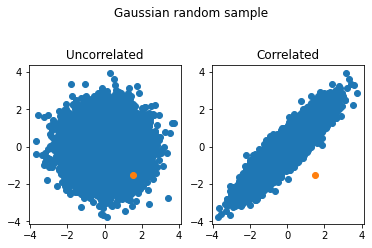

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Gaussian random sample')
ax1.set_aspect('equal')
ax1.set_title('Uncorrelated')
ax1.scatter(X_nocorr[:,0], X_nocorr[:,1])
ax1.scatter(1.5, -1.5)
ax2.set_title('Correlated')
ax2.set_aspect('equal')
ax2.scatter(X_corr[:,0], X_corr[:,1])
ax2.scatter(1.5, -1.5)
plt.show()

# Gaussian Mixture

In [4]:
gm1 = GaussianMixture(n_components=1, n_init=10)  # unimodal fit
gm2 = GaussianMixture(n_components=1, n_init=10)  # unimodal fit

gm1.fit(X_nocorr)
gm2.fit(X_corr)

# some stats are available:
gm1.weights_
gm2.weights_
gm1.means_
gm2.means_
gm1.covariances_
gm2.covariances_

array([[[0.983423  , 0.88929973],
        [0.88929973, 0.99299487]]])

In [6]:
# scores for the point we consider which is an outlier only for the correlated sample:
print(gm1.score_samples([[1.5, -1.5]]))
print(gm2.score_samples([[1.5, -1.5]]))  # a very different score of course!!!

[-4.09257434]
[-23.82678798]


In [8]:
## the scores are symmetrical:
print(gm1.score_samples([[1.5, -1.5]]))
print(gm2.score_samples([[1.5, -1.5]]))
print(gm1.score_samples([[1.5, 1.5]]))
print(gm2.score_samples([[1.5, 1.5]]))
print(gm1.score_samples([[-1.5, 1.5]]))
print(gm2.score_samples([[-1.5, 1.5]]))
print(gm1.score_samples([[-1.5, -1.5]]))
print(gm2.score_samples([[-1.5, -1.5]]))

[-4.09257434]
[-23.82678798]
[-4.10681461]
[-2.18720159]
[-4.07680608]
[-23.66728318]
[-4.13600412]
[-2.20207494]


In [10]:
# add our famous point at the end so we can easily check all outlier points:
X_corr_with_outlier = np.vstack([X_corr, [1.5, -1.5]])
X_nocorr_with_outlier  = np.vstack([X_nocorr, [1.5, -1.5]])


d1 = gm1.score_samples(X_nocorr_with_outlier)
d2 = gm2.score_samples(X_corr_with_outlier)
density_threshold1 = np.percentile(d1, 0.01)  # this is specified as percentage so it's 1/10000
density_threshold2 = np.percentile(d2, 0.01)

print(density_threshold1)
print(density_threshold2)

-9.8203402274606
-9.815705946785931


In [11]:
# this shows clearly that in the correlated case (1.5, -1.5) is a strong outlier:
X_nocorr_with_outlier[d1 < density_threshold1]   # (1.5, -1.5) is not an oulier in the uncorrelated case

array([[ 3.41931987, -2.77159372]])

In [12]:
X_corr_with_outlier[d2 < density_threshold2]     # (1.5, -1.5) is an oulier in the correlated case

array([[ 1.5, -1.5]])

# COPOD

![copod](img/copod.png)

In [13]:
cpd1 = COPOD()
cpd1.fit(X_nocorr)

cpd2 = COPOD()
cpd2.fit(X_corr)

COPOD(contamination=0.1, n_jobs=1)

In [14]:
cpd1.predict(np.array([[1.5, -1.5]])) # (1.5, -1.5) is not an outlier, which we expect

array([0])

In [15]:
cpd2.predict(np.array([[1.5, -1.5]])) # (1.5, -1.5) is not an outlier, which we *don't* expect

array([0])

In [16]:
# and they get the exact same score because their correlation is ignored:
print(cpd1.decision_function(np.array([[1.5, -1.5]])))
print(cpd2.decision_function(np.array([[1.5, -1.5]])))

[4.11815249]
[4.11815249]


In [17]:
# and points which are at the same distance with same density get different scores:
print(cpd1.decision_function(np.array([[1.5, 1.5]])))
print(cpd2.decision_function(np.array([[1.5, 1.5]])))
print(cpd1.decision_function(np.array([[-1.5, 1.5]])))
print(cpd2.decision_function(np.array([[-1.5, 1.5]])))
print(cpd1.decision_function(np.array([[-1.5, -1.5]])))
print(cpd2.decision_function(np.array([[-1.5, -1.5]])))

[2.80421656]
[2.80421656]
[4.11491792]
[4.11491792]
[5.42885386]
[5.42885386]
